# Notebook of Figure 4 of manuscript titled: _Variability of the kinetic energy in seasonally ice-covered oceans_.
by Josue Martinez-Moreno, Camille Lique, Claude Talandier, Quentin
Jamet, & Anne-Marie Treguier

This figure shows a comparision between the ocean velocities and ice velocities. There is a strong correlation between them when the concentration of the ice decreases due to the seasonality. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
# import xrftd
import matplotlib.colors as colors

In [2]:
import nc_time_axis

In [3]:
from dask.distributed import Client
import dask
import os

# os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))
client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42381 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42381/status,
Dashboard: http://127.0.0.1:42381/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56068,Workers: 8
Dashboard: http://127.0.0.1:42381/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:51767,Total threads: 1
Dashboard: http://127.0.0.1:45335/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:57041,


In [4]:
from utils import Import_Expt_Front, date_fmt

### Load data and grid

In [5]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/'
EXF = Import_Expt_Front(folder)

In [6]:
exp_filter = ['expt_001','expt_002','expt_003','expt_004','expt_005','expt_007','expt_008','expt_009','expt_010','expt_250m_test']

In [7]:
dataset_icecond_1d = EXF.import_multipe_expt('icemod',vars_of_interest=['iceconc','icevolu'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002")


In [8]:
dataset_icerheo_1d = EXF.import_multipe_expt('icerheo',vars_of_interest=['sivelv','sivelu'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1},decode_cf=False)


In [9]:
dataset_icerheo_1d = xr.decode_cf(dataset_icerheo_1d).sel(time_counter="0002").isel(y=slice(1,-2))

In [10]:
dataset_u_1d = EXF.import_multipe_expt('grid_U',vars_of_interest=['uoce'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002").isel(y=slice(1,-2))


In [11]:
dataset_v_1d = EXF.import_multipe_expt('grid_V',vars_of_interest=['voce'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002").isel(y=slice(1,-2))


In [12]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/GRID/domain_zgr_800x1200x50xr.nc').isel(y=slice(1,-2))

Read ice concentration

In [13]:
iceconc = dataset_icecond_1d.iceconc_006.isel(y=slice(1,-2))

In [14]:
def interp_field(x,y):
    x_centered = (x + x.roll(x=1))/2
    y_centered = (y + y.roll(y=1))/2
    return x_centered,y_centered

In [15]:
# Load ocean velocities, interpolate data to be in the same grid.
u_1d, v_1d = interp_field(dataset_u_1d.uoce_006.isel(depthu=0).squeeze(),dataset_v_1d.voce_006.isel(depthv=0).squeeze())


In [16]:
# Load ice velocities
u_ice = dataset_icerheo_1d.sivelu_006
v_ice = dataset_icerheo_1d.sivelv_006

In [17]:
# Compute mean ocen velocities in the presence of sea-ice. 
mean_season_u_i = u_1d.where(iceconc>0.).groupby("time_counter.season").mean().compute()
mean_season_v_i = v_1d.where(iceconc>0).groupby("time_counter.season").mean().compute()


In [18]:
# Compute ocean and ice velocities magnitudes.
U_o_mag = np.sqrt(u_1d**2+v_1d**2)
U_i_mag = np.sqrt(u_ice**2 + v_ice**2)

In [19]:
# Compute time series of the velocities magnitudes.
mean_U_o_mag = U_o_mag.mean(('x','y')).compute()
mean_U_i_mag = U_i_mag.mean(('x','y')).compute()

In [20]:
# Compute seasonal averages of the velocities magnitudes.
seasonal_U_o_mag = U_o_mag.where(U_o_mag!=0).groupby("time_counter.season").mean().compute()
seasonal_U_i_mag = U_i_mag.where(U_i_mag!=0).groupby("time_counter.season").mean().compute()


## Compute correlation between the time series of the velocities magnitudes

In [21]:
import matplotlib.gridspec as gridspec
import scipy.stats

In [22]:
corr = np.zeros(len(U_o_mag.time_counter))
pval = np.zeros(len(U_o_mag.time_counter))

for time in range(0,len(U_o_mag.time_counter)):
    print(time)
    
    x = U_o_mag.isel(time_counter=time).values.ravel()
    y = U_i_mag.isel(time_counter=time).values.ravel()
    
    corr[time] = scipy.stats.spearmanr(x, y)[0]
    pval[time] = scipy.stats.spearmanr(x, y)[1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


/dev/shm/pbs.3980998.datarmor0/ipykernel_6720/2133219106.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr[time] = scipy.stats.spearmanr(x, y)[0]
/dev/shm/pbs.3980998.datarmor0/ipykernel_6720/2133219106.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pval[time] = scipy.stats.spearmanr(x, y)[1]


211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364


Assign coordinates for plotting.

In [23]:
seasonal_U_i_mag = seasonal_U_i_mag.assign_coords({"nav_lon":grid.x_coord,"nav_lat":grid.y_coord})
mean_season_u_i = mean_season_u_i.assign_coords({"nav_lon":grid.x_coord,"nav_lat":grid.y_coord})
mean_season_v_i = mean_season_v_i.assign_coords({"nav_lon":grid.x_coord,"nav_lat":grid.y_coord})


U_o_mag = U_o_mag.assign_coords({"nav_lon":grid.x_coord,"nav_lat":grid.y_coord})
U_i_mag = U_i_mag.assign_coords({"nav_lon":grid.x_coord,"nav_lat":grid.y_coord})


In [24]:
X = mean_season_u_i.nav_lon.values
Y = mean_season_u_i.nav_lat.values

In [25]:
# Scale to normalize streamplots
line_scale = seasonal_U_i_mag/seasonal_U_i_mag.max()

In [26]:
import datetime

def date_fmt(date):
    if len(date)>2:
        format = '%m-%d'
        outformat = '%d - %B'
    else:
        format = '%m'
        outformat = '%B'
    return datetime.datetime.strptime(str(date), format).strftime(outformat)

In [27]:
mean_iceconc = dataset_icecond_1d.iceconc_006.mean(('x','y')).compute()
mean_icevolu = dataset_icecond_1d.icevolu_006.mean(('x','y')).compute()

/dev/shm/pbs.3980998.datarmor0/ipykernel_6720/91078930.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(updated_labels,fontsize=8)


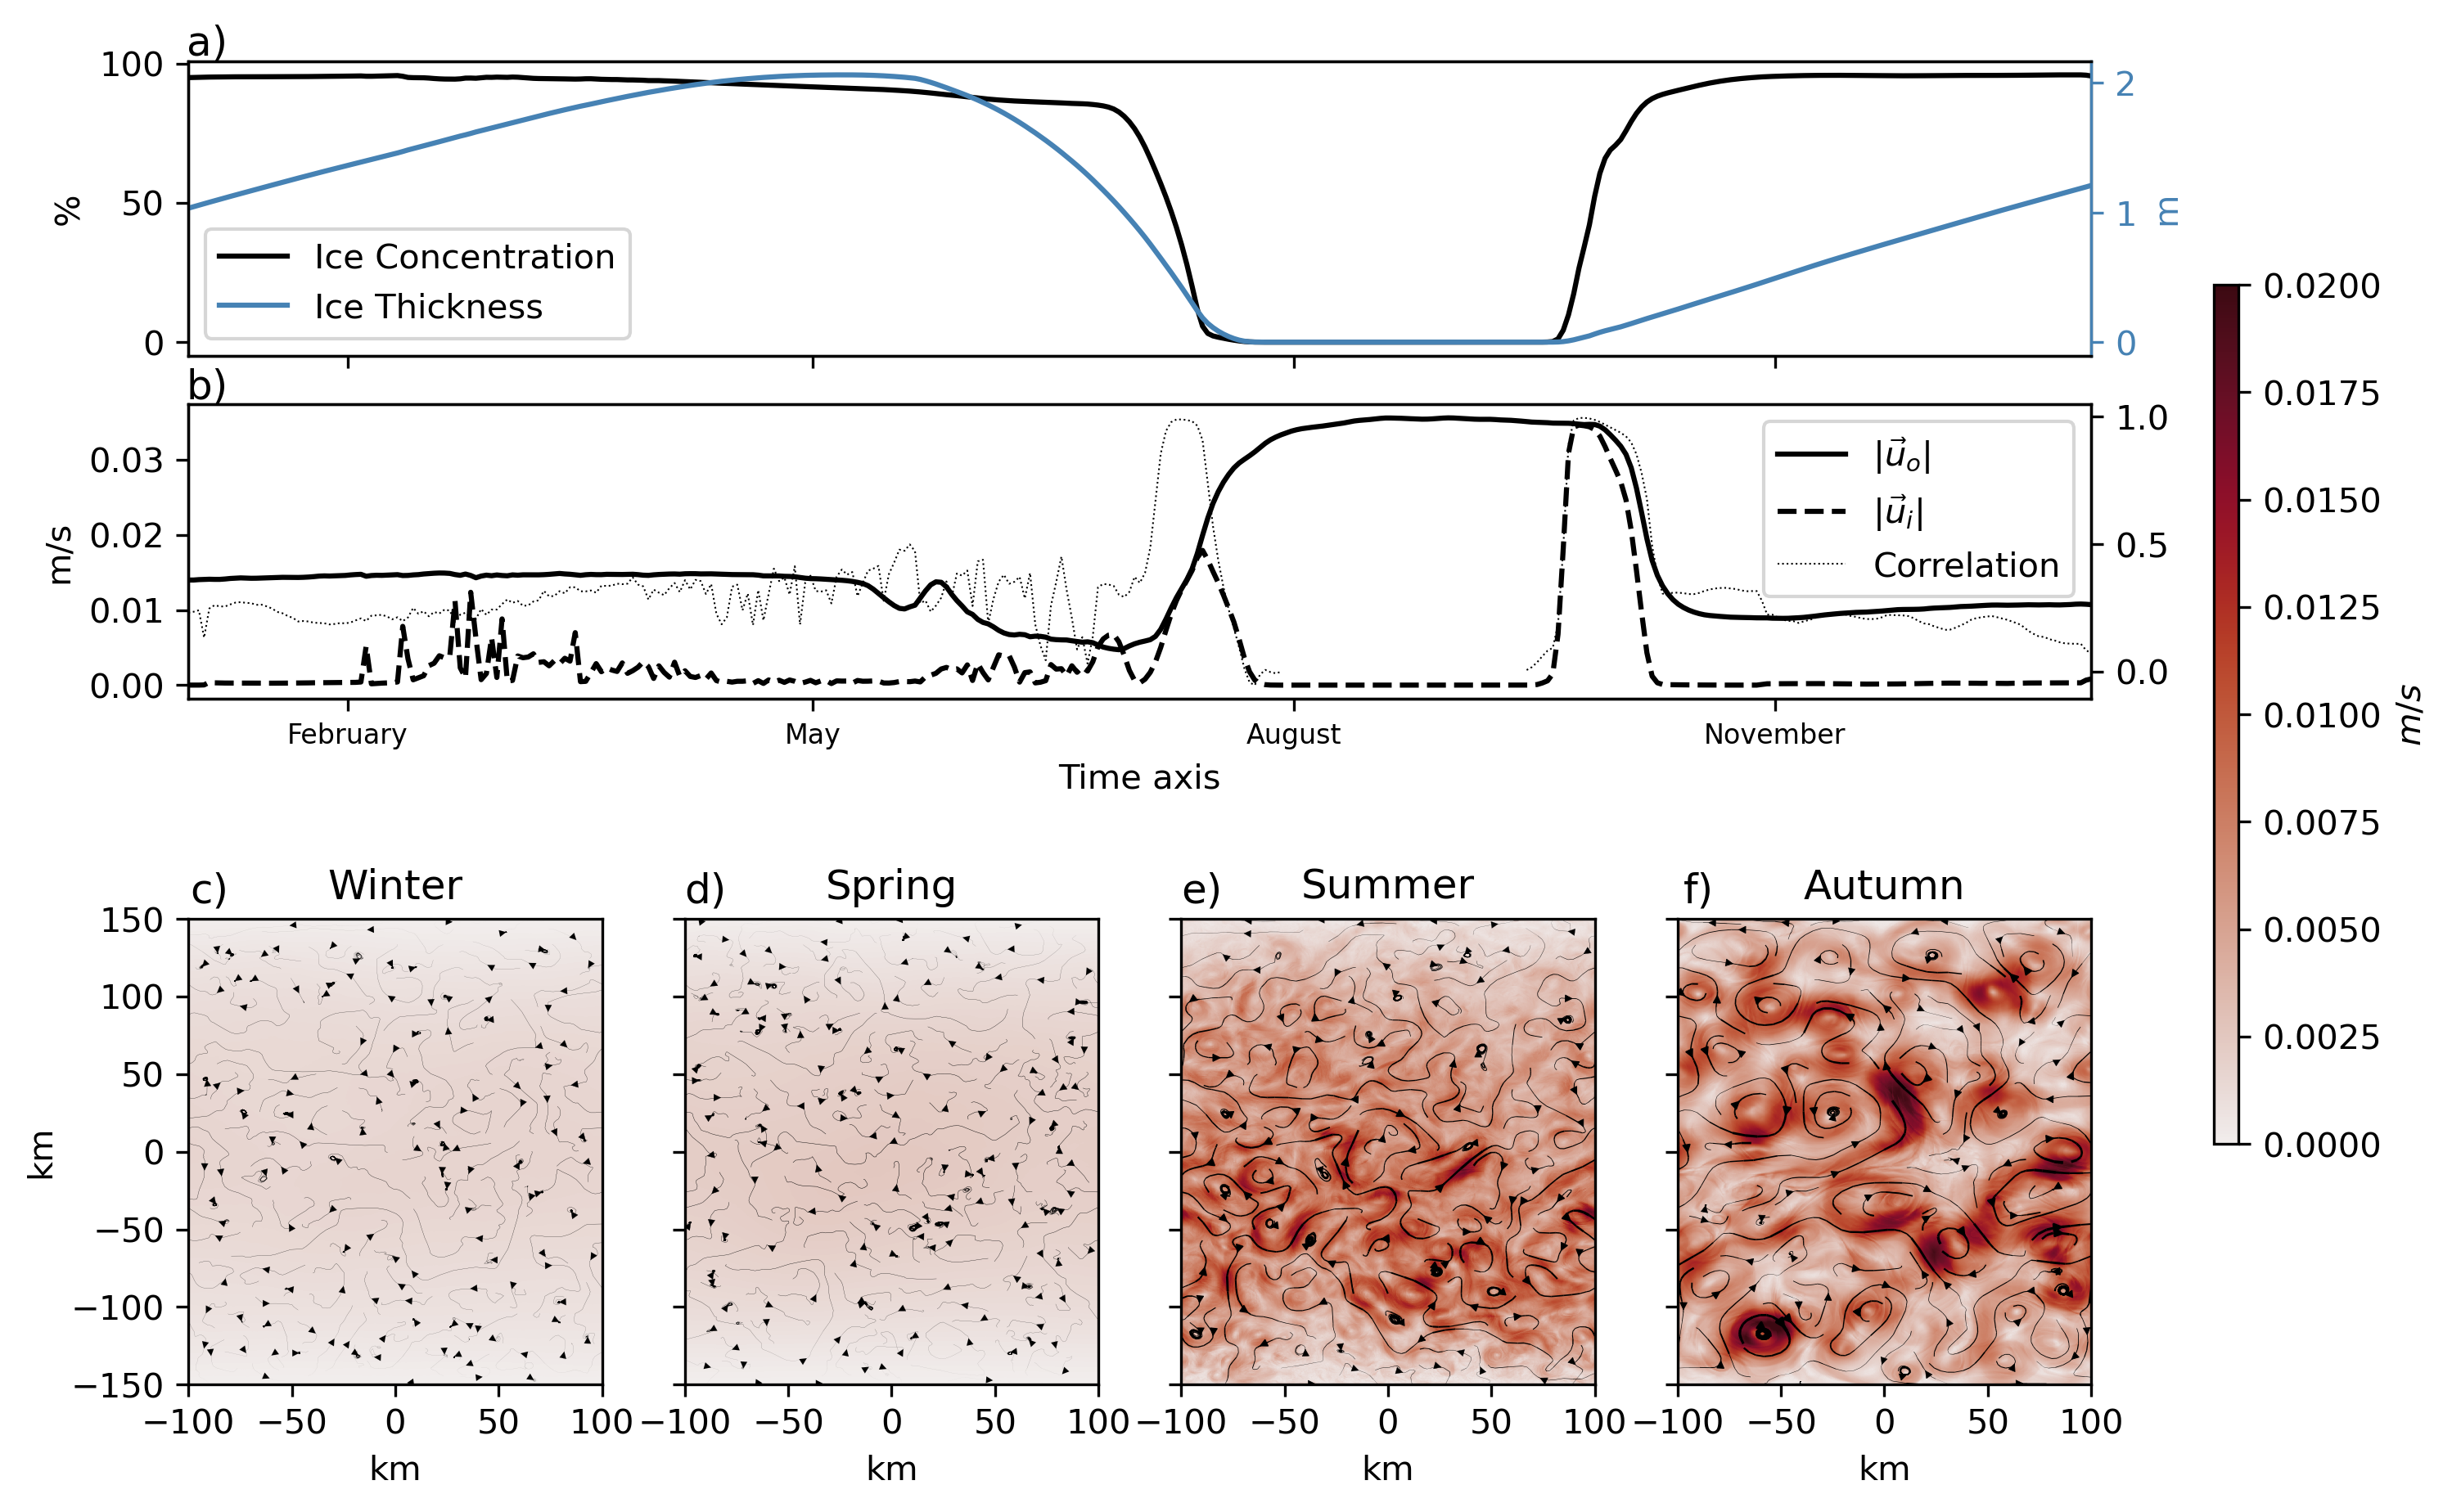

In [28]:
fig = plt.figure(figsize=(10,7), dpi=300)

gs0 = gridspec.GridSpec(8, 4, figure=fig)

ax0 = fig.add_subplot(gs0[0:2,:])

(mean_iceconc*100).plot(ax=ax0, color = 'k', label="Ice Concentration")
ax0.plot(mean_iceconc.time_counter[0],0, color = 'steelblue', label="Ice Thickness")

ax0.set_ylabel("%")
ax0.legend(loc=0)

ax0_t = ax0.twinx()
mean_icevolu.plot(ax=ax0_t, color = 'steelblue', label="Ice Thickness")

ax0_t.set_xlabel("")
ax0.set_xlabel("")

ax0_t.set_ylabel("m",color='steelblue')
ax0_t.spines['right'].set_color('steelblue')
ax0_t.xaxis.label.set_color('steelblue')
ax0_t.tick_params(axis='y', colors='steelblue')

ax0.set_xlim([mean_iceconc.time_counter[0].values,mean_iceconc.time_counter[-1].values])

# ax0_t.set_ylim(mean_iceconc.time_counter[0],mean_iceconc.time_counter[-1])

ax1 = fig.add_subplot(gs0[2:4,:])

mean_U_o_mag.plot(ax=ax1, color = 'k', label=r"$|\vec{u}_o|$")
mean_U_i_mag.plot(ax=ax1, linestyle='--', color = 'k', label=r"$|\vec{u}_i|$")
ax1.plot(mean_U_o_mag.time_counter[0], 0, linewidth=0.5,  linestyle=':', color = 'k', label=r"Correlation")

ax1_t = ax1.twinx()
ax1_t.plot(U_o_mag.time_counter, corr, linewidth=0.5,  linestyle=':', color = 'k', label=r"Corr")

ax1.legend()

ax1.set_xlim([mean_U_o_mag.time_counter[0].values,mean_U_o_mag.time_counter[-1].values])

ax2 = fig.add_subplot(gs0[5:,0])

vel = seasonal_U_i_mag.sel(season='DJF').plot(x="nav_lon", y="nav_lat", ax=ax2, add_colorbar=False,cmap=cm.cm.amp,vmin=0,vmax=0.02,rasterized=True)
ax2.streamplot(X, Y, mean_season_u_i.sel(season='DJF').values, mean_season_v_i.sel(season='DJF').values, color='k',linewidth=line_scale.sel(season='DJF').values ,arrowsize=0.5)

ax3 = fig.add_subplot(gs0[5:,1])

seasonal_U_i_mag.sel(season='MAM').plot(x="nav_lon", y="nav_lat", ax=ax3, add_colorbar=False,cmap=cm.cm.amp,vmin=0,vmax=0.02,rasterized=True)
ax3.streamplot(X, Y, mean_season_u_i.sel(season='MAM').values, mean_season_v_i.sel(season='MAM').values, color='k',linewidth=line_scale.sel(season='MAM').values,arrowsize=0.5)

ax4 = fig.add_subplot(gs0[5:,2])

seasonal_U_i_mag.sel(season='JJA').plot(x="nav_lon", y="nav_lat", ax=ax4, add_colorbar=False,cmap=cm.cm.amp,vmin=0,vmax=0.02,rasterized=True)
ax4.streamplot(X, Y, mean_season_u_i.sel(season='JJA').values, mean_season_v_i.sel(season='JJA').values, color='k',linewidth=line_scale.sel(season='JJA').values,arrowsize=0.5)

ax5 = fig.add_subplot(gs0[5:,3])

seasonal_U_i_mag.sel(season='SON').plot(x="nav_lon", y="nav_lat", ax=ax5, add_colorbar=False,cmap=cm.cm.amp,vmin=0,vmax=0.02,rasterized=True)
ax5.streamplot(X, Y, mean_season_u_i.sel(season='SON').values, mean_season_v_i.sel(season='SON').values, color='k',linewidth=line_scale.sel(season='SON').values,arrowsize=0.5)

ax1.set_ylabel("m/s")
ax2.set_ylabel("km")

ax = [ax2,ax3,ax4,ax5]

[ a.set_xlim((-100,100)) for a in ax ]
[ a.set_ylim((-150,150)) for a in ax ]
[ a.set_xlabel("km") for a in ax ]
[ a.yaxis.set_ticklabels([]) for a in ax[1:] ]
[ a.set_ylabel("") for a in ax[1:] ]
             
Seasons = ["Winter","Spring","Summer","Autumn"]
[ ax[a].set_title(Seasons[a]) for a in range(len(ax)) ]

plt.subplots_adjust(hspace=0.4)

ax0.text(0.01, 1.06, 'a)', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes,fontsize=12)
ax1.text(0.01, 1.06, 'b)', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes,fontsize=12)
ax2.text(0.05, 1.06, 'c)', horizontalalignment='center', verticalalignment='center', transform = ax2.transAxes,fontsize=12)
ax3.text(0.05, 1.06, 'd)', horizontalalignment='center', verticalalignment='center', transform = ax3.transAxes,fontsize=12)
ax4.text(0.05, 1.06, 'e)', horizontalalignment='center', verticalalignment='center', transform = ax4.transAxes,fontsize=12)
ax5.text(0.05, 1.06, 'f)', horizontalalignment='center', verticalalignment='center', transform = ax5.transAxes,fontsize=12)

cax = fig.add_axes([0.95, 0.25, 0.01, 0.5])
cbar = fig.colorbar(vel, cax=cax, orientation='vertical')
cbar.set_label(r"$m/s$")


plt.draw()

labels = [item.get_text() for item in ax1.get_xticklabels()]
updated_labels = [ date_fmt(label[5:10]) for label in labels]
ax1.set_xticklabels(updated_labels,fontsize=8)

ax0_t.axes.xaxis.set_ticklabels([])

plt.savefig('./figures/Fig_6_ice_scales.pdf', dpi=300, bbox_inches='tight')


**Figure 4.** Time-series of the domain average (a) ice concentration and thickness, and (b) ocean surface velocity magnitude ($|\vec{u}_o|$) and ice velocity magnitude ($|\vec{u}_i|$). The dotted line corresponds to the Spearman correlation coefficient between the ocean and ice velocities for each day of the second year of the simulation. Seasonally averaged ice velocity magnitude and ocean velocities streamlines in the presence of sea ice (i.e. where ice concentrations are larger than 0\%) are shown for c) winter, d) spring, e) summer, and f) autumn.

# Extra diagnostics

In [29]:
seasonal_U_i_mag.mean().compute()

<xarray.DataArray ()> Size: 4B
array(0.00372763, dtype=float32)

In [30]:
seasonal_U_o_mag.mean().compute()

<xarray.DataArray ()> Size: 4B
array(0.01689081, dtype=float32)
Coordinates:
    depthu   float32 4B 0.5
    depthv   float32 4B 0.5